In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.utils import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
splitext,Split the extension from a pathname
expanduser,Expand ~ and ~user constructions
isabs,Test whether a path is absolute
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on


In [3]:
clfname = 'clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11.sklmodel'

clf = load_clf(clfname)

# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (6.29922, 6.29922)  # 16 cm
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'  # serif

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 20)

# rc('text', usetex=True)

CC instances (<=0.5): 1.00. Min median max scores = [0.41, 0.44, 0.49]

,Resp. multiplication factor,Correctly classified ratio
0,1000.0000,1.000
1,100.0000,0.984
2,10.0000,0.480
3,1.0000,NaN
4,0.1000,0.112
5,0.0100,0.617
6,0.0010,1.000
7,0.0001,1.000


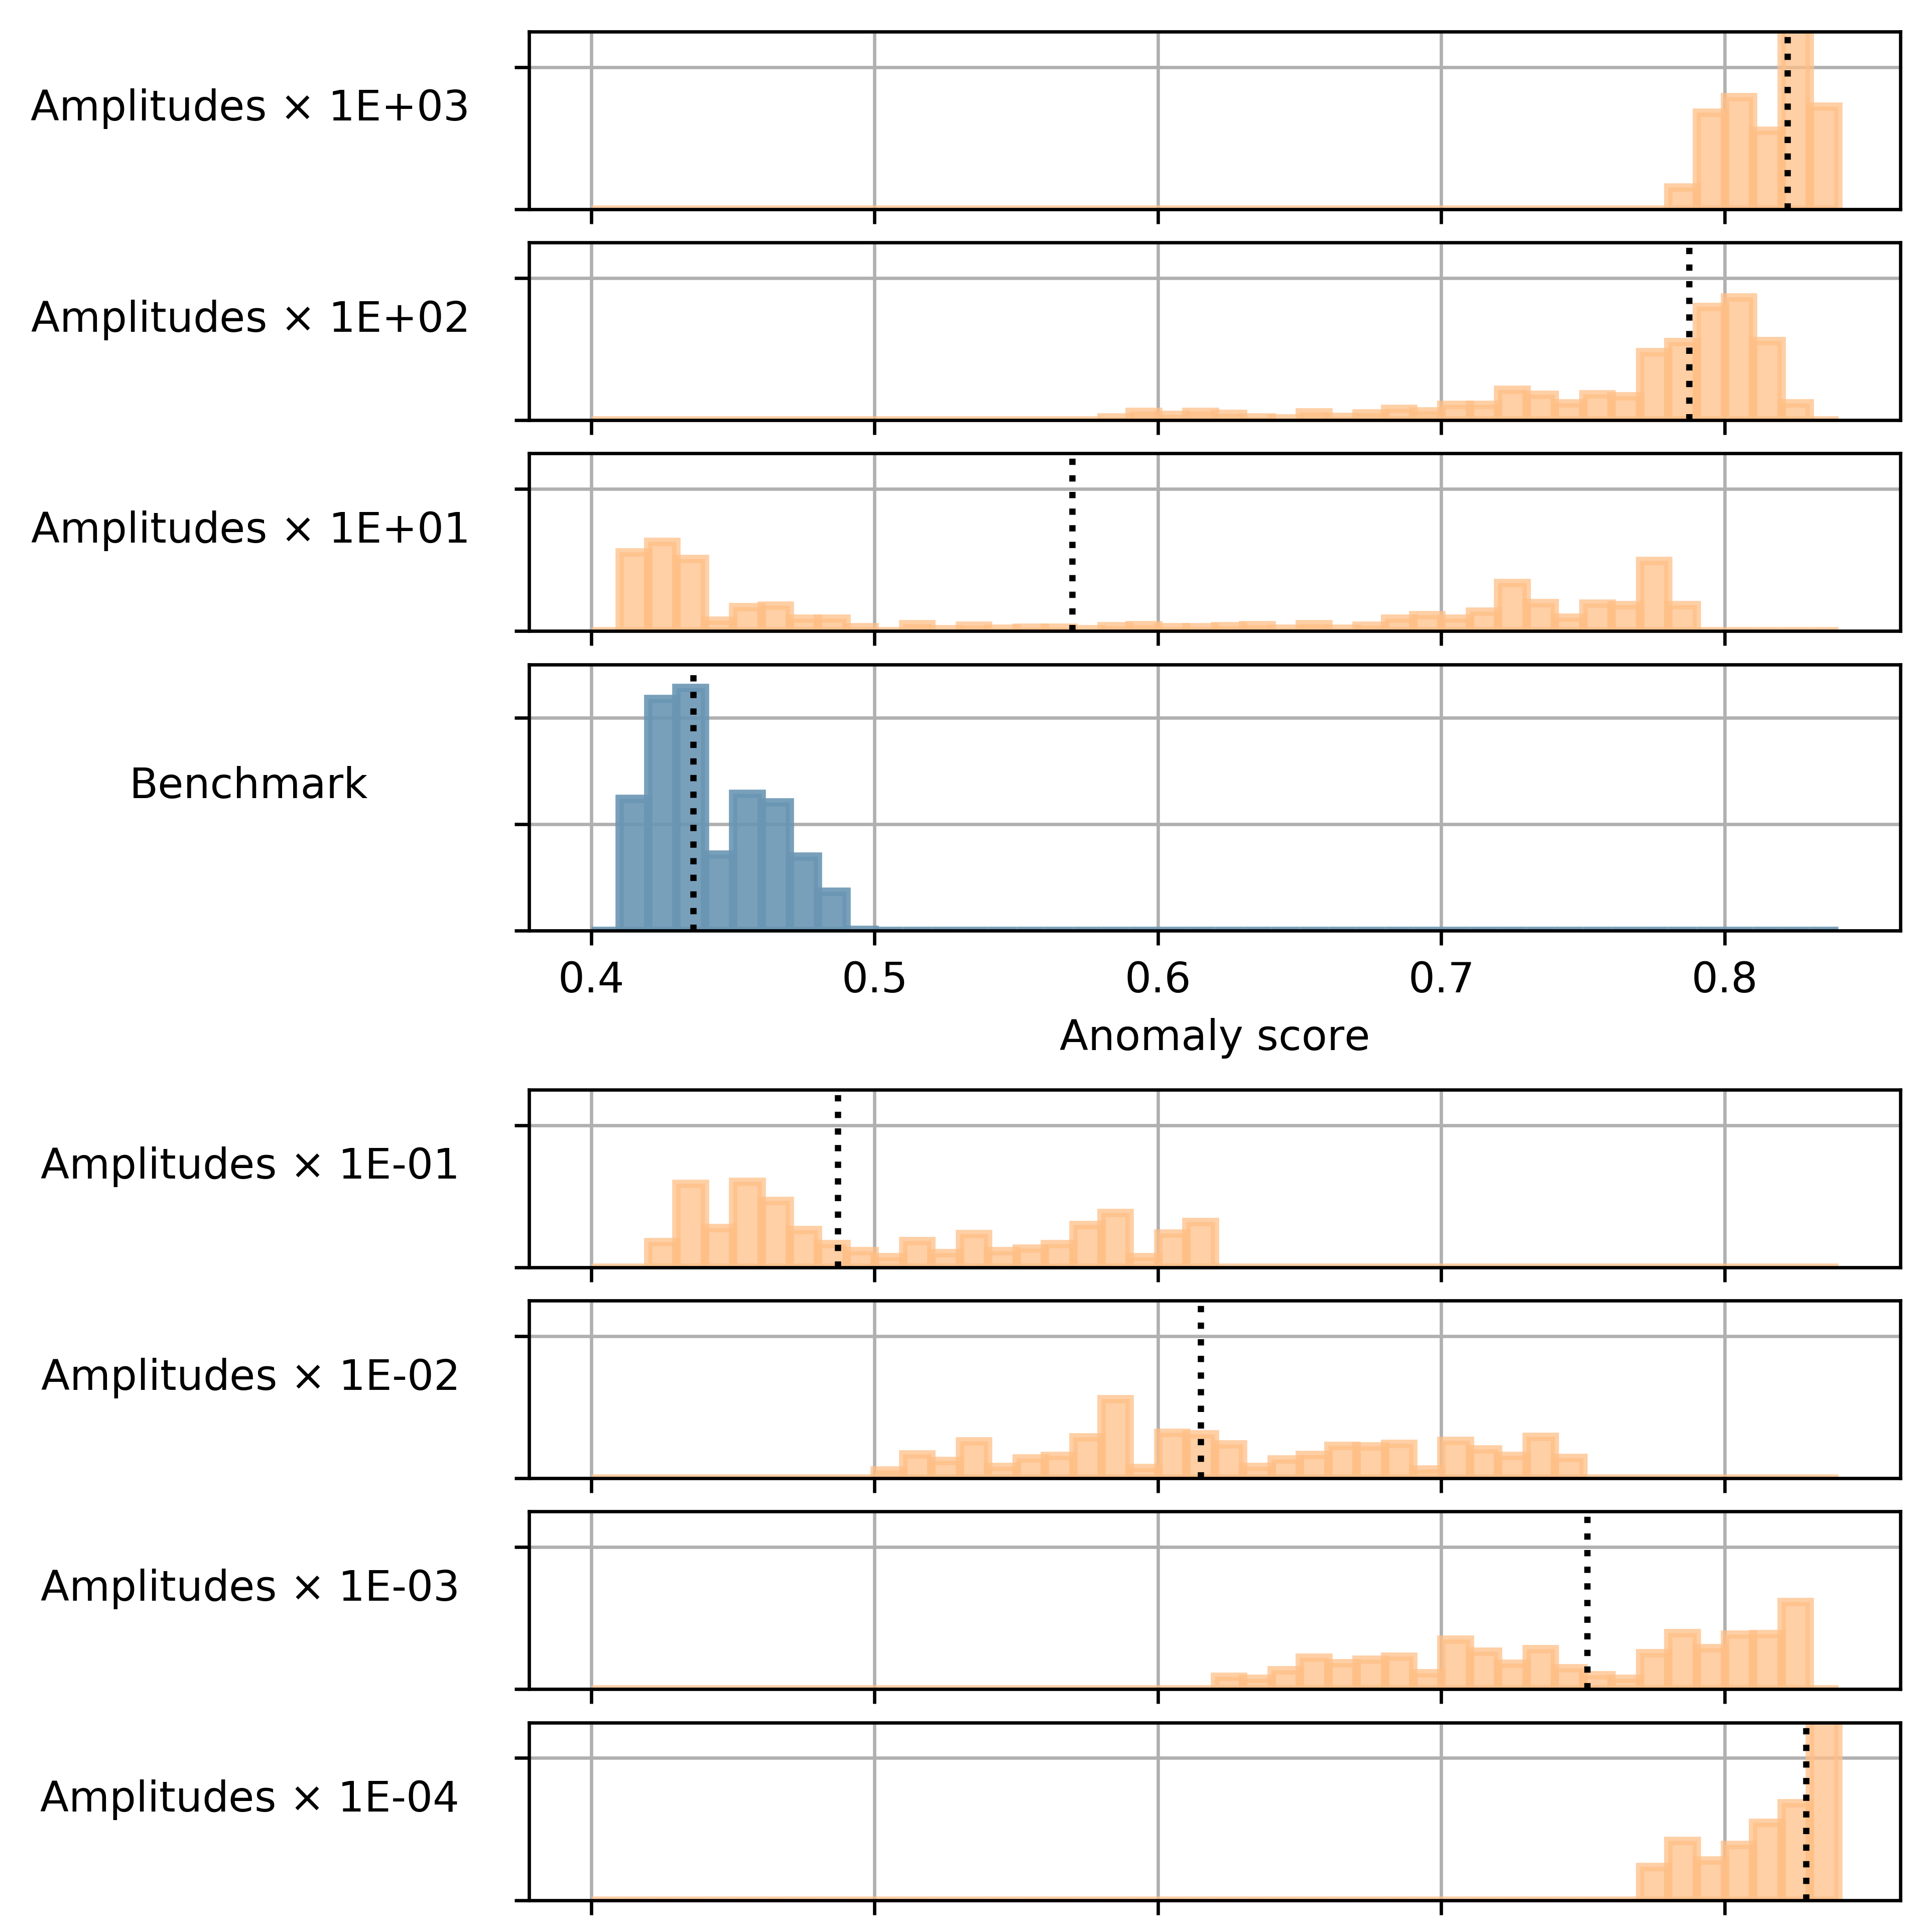

In [10]:
# robustness wrt gain change in the response
# create an array of 100 "good" psd periods (see figure above)

factors =  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000][::-1]  # [0.0005, 0.001, 0.01, 0.1, 1, 10, 100, 150, 1000]

fig = plt.figure(constrained_layout=True)
gsp = fig.add_gridspec(len(factors), 1, hspace=0,
                       height_ratios = [1,1,1,1.5,1,1,1,1])  # width_ratios=[1,5], hspace=0)
axss = []

bins = np.arange(0.4, 0.85, 0.01)

colors = get_colors(2)

# low and high ranges (in dB) of "undecided zone"
lpsd = [-152, -138]
hpsd = [-100, -66]

psds = np.random.uniform(lpsd[1],hpsd[0], [1000, 1]) # A 2x3 array
scores = -clf.score_samples(psds)
cc = (scores <= 0.5).sum() / float(len(scores))
printhtml(f'<h4>CC instances (<=0.5): {cc:.2f}. Min median max scores = [{np.nanmin(scores):.2f}, {np.nanmedian(scores):.2f}, {np.nanmax(scores):.2f}]</h4>')
data = {'Resp. multiplication factor': [], 'Correctly classified ratio': []}
for i, factor in enumerate(factors):
    ax = fig.add_subplot(gsp[i, 0])
    # factor = 10.0 ** N
    if factor == 1:
        cc_ = np.nan  # cc
        scores_ = scores
    else:
        psds_ = np.copy(psds) - 10 * np.log10(factor ** 2)
        scores_ = -clf.score_samples(psds_)
        
        cc_ = (scores_ > 0.6).sum() / float(len(scores_))
        # cc_ = (np.abs(scores_ - scores) > .1).sum() / float(len(scores_))
        # cc_ = (scores_ > 0.75).sum() / float(len(scores_))
    ax.set_axisbelow(True)
    ax.grid()
    ax.hist(scores_, bins=bins, alpha=0.75 if factor !=1 else .9, color=colors[0 if factor==1 else 1],
            edgecolor=colors[0 if factor==1 else 1], linewidth=2)
    # axs[i].set_ylabel(f'Factor: 10^{int(np.log10(factor))}', rotation=0, labelpad=100, va='top')
    # bbox_to_anchor: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y. 
    # ax.annotate(f'Factor: {factor:.2E}', xy=(0,1))
    if factor != 1:  # i < len(factors)-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Anomaly score')
    ax.set_ylim([0, 250])
    ax.set_yticklabels([])
    
    ax.axvline(np.nanmedian(scores_), linestyle=':', color='k')
    if factor == 1:
        # text = f'\nBenchmark PSDs (median score: {np.nanmedian(scores_):.2f})'
        # ax.set_title(text)
        text = f'Benchmark'
        ax.set_ylabel(text, rotation=0, labelpad=60, va='baseline')
    else:
        # text = f'Amplitudes $\\times$ {factor:.0E}\nmedian score: {np.nanmedian(scores_):.2f}'
        text = f'Amplitudes $\\times$ {factor:.0E}'
        ax.set_ylabel(text, rotation=0, labelpad=60, va='baseline')
   
    axss.append(ax)
        
#     ax_label = fig.add_subplot(gsp[i, 0])
#     ax_label.text(0.8, 1, text, ha='right', va='top', rotation=0, linespacing=2)  # , family='monospace') 
#     ax_label.set_axis_off()
    
    data['Resp. multiplication factor'].append(factor)
    data['Correctly classified ratio'].append(cc_)

# samey(axss)
display(pd.DataFrame(data))